# Computer Assignment 4: CNN Segmentation
## Alaqian Zafar - aaz7118

## Table of Contents
- <a href='#p1a'>Part (a)</a>
- <a href='#p1b'>Part (b)</a>
- <a href='#p1c'>Part (c)</a>
    - [Architecture](#Architecture)
    - [Loss Function](#Loss-Function)
- <a href='#p1d'>Part (d)</a>
- <a href='#p2a'>Part (e)</a>
- <a href='#p2b'>Part (f)</a>
- <a href='#p2c'>Part (g)</a>

In [1]:
import os
import random

import cv2
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
from torchvision import transforms
from tqdm import tqdm

%matplotlib inline

In [2]:
try:
    from google.colab import drive
    drive.mount('/content/drive')
    path = '/content/drive/MyDrive/ECE-GY 6123 Image and Video Processing/Computer Assignments/CA04/archive'
except:
    path = 'archive'

<a id='p1a'></a>
##### (a) Cut the FudanPed dataset into an 80-10-10 train-val-test split.

[Table of Contents](#Table-of-Contents)

In [3]:
image_paths = sorted([os.path.join(path, "PNGImages", image) for image in os.listdir(os.path.join(path, "PNGImages"))])
mask_paths = sorted([os.path.join(path, "PedMasks", mask) for mask in os.listdir(os.path.join(path, "PedMasks"))])

indices = list(range(len(image_paths)))
train_indices = random.sample(indices, k=int(len(indices)*0.8))
val_indices = random.sample(set(indices)-set(train_indices), k=int(len(indices)*0.1))
test_indices = list(set(indices)-set(train_indices)-set(val_indices))

train_image_paths = [image_paths[i] for i in train_indices]
train_mask_paths = [mask_paths[i] for i in train_indices]
val_image_paths = [image_paths[i] for i in val_indices]
val_mask_paths = [mask_paths[i] for i in val_indices]
test_image_paths = [image_paths[i] for i in test_indices]
test_mask_paths = [mask_paths[i] for i in test_indices]

class PennFudanDataset(Dataset):
    def __init__(self, image_paths, mask_paths, transform=None):
        self.image_paths = image_paths
        self.mask_paths = mask_paths
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image = cv2.imread(self.image_paths[idx])
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        mask = cv2.imread(self.mask_paths[idx], 0)
        # Set all values greater-than or equal-to 1 to 255.
        mask = np.clip(mask, 0, 1)*255
        merged_image = np.concatenate((image, mask[:, :, None]), axis=2)
        merged_image = transforms.ToTensor()(merged_image)
        if self.transform:
            merged_image = self.transform(merged_image)
        image = merged_image[:3, :, :]
        mask = merged_image[3, :, :]
        return image, mask

<a id='p1b'></a>
##### (b) Apply data augmentation to your dataset during training and show an example of your data augmentation in your report.

[Table of Contents](#Table-of-Contents)

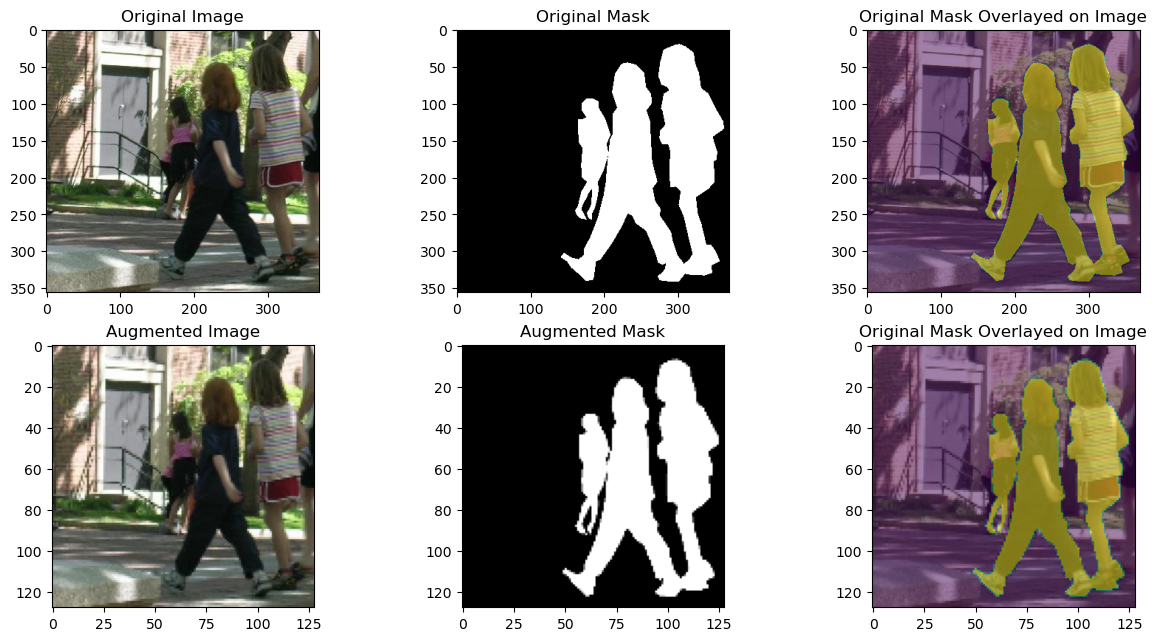

In [4]:
# Plot a subplot of the original and the augmented image and mask
train_dataset = PennFudanDataset(train_image_paths, train_mask_paths)
image, mask = train_dataset[0]
fig, ax = plt.subplots(2, 3, figsize=(15, 7.5))
ax[0,0].imshow(image.permute(1, 2, 0))
ax[0,0].set_title("Original Image")
ax[0,1].imshow(mask, cmap="gray")
ax[0,1].set_title("Original Mask")
ax[0,2].imshow(image.permute(1, 2, 0))
ax[0,2].imshow(mask, alpha=0.5)
ax[0,2].set_title("Original Mask Overlayed on Image")

image_size = (128,128)
augmentation = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.Resize(image_size)
    ])
augmented_train_dataset = PennFudanDataset(train_image_paths, train_mask_paths, transform=augmentation)
image, mask = augmented_train_dataset[0]
ax[1,0].imshow(image.permute(1, 2, 0))
ax[1,0].set_title("Augmented Image")
ax[1,1].imshow(mask, cmap="gray")
ax[1,1].set_title("Augmented Mask")
ax[1,2].imshow(image.permute(1, 2, 0))
ax[1,2].imshow(mask, alpha=0.5)
ax[1,2].set_title("Original Mask Overlayed on Image")

batchsize = 8

train_loader = DataLoader(augmented_train_dataset, batch_size=batchsize, shuffle=True)
test_dataset = PennFudanDataset(
    test_image_paths,
    test_mask_paths, 
    transform=transforms.Resize(image_size))
test_loader = DataLoader(test_dataset, batch_size=batchsize, shuffle=False)
val_dataset = PennFudanDataset(
    val_image_paths, 
    val_mask_paths, 
    transform=transforms.Resize(image_size))
val_loader = DataLoader(test_dataset, batch_size=batchsize, shuffle=False)

<a id='p1c'></a>
##### (c) Implement and train a CNN for binary segmentation on your train split. Describe your network architecture, loss function, and any training hyper-parameters. You may implement any architecture you'd like, **but the implementation must be your own code.**

[Table of Contents](#Table-of-Contents)

#### Architecture

`x` (input) → `Conv_BN_ReLU1` → `Downsample1` → `x1` → `x2` → `Conv_BN_ReLU2` → `x3` → `Downsample2` → `x4` → `Conv_BN_ReLU3` → `x5` → `Upsample1` → `x6` → `cat(x3)` → `x7` → `Conv_BN_ReLU4` → `x8` → `Upsamle2` → `x9` → `cat(x1)` → `x10` → `Conv_BN_ReLU5` → `x11` → `conv6` → `x12` → `sigmoid` → `x13` (output)

![Architecture](UNET.png)

In [5]:
class UNET(nn.Module):
    def __init__(self):
        super(UNET, self).__init__()
        self.Conv_BN_ReLU1 = self._Conv_BN_ReLU(3, 16)
        self.Downsample1 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.Conv_BN_ReLU2 = self._Conv_BN_ReLU(16, 32)
        self.Downsample2 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.Conv_BN_ReLU3 = self._Conv_BN_ReLU(32, 32)
        self.Upsample1 = nn.Upsample(scale_factor=2, mode="bilinear", align_corners=True)
        self.Conv_BN_ReLU4 = self._Conv_BN_ReLU(64, 16)
        self.Upsample2 = nn.Upsample(scale_factor=2, mode="bilinear", align_corners=True)
        self.Conv_BN_ReLU5 = self._Conv_BN_ReLU(32, 16)
        self.Conv6 = nn.Conv2d(16, 1, kernel_size=1)

    def _Conv_BN_ReLU(self, in_channels, out_channels):
        return nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding='same'),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding='same'),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )
    
    def forward(self, x):
        x1 = self.Conv_BN_ReLU1(x) # 3x128x128 -> 16x128x128
        x2 = self.Downsample1(x1) # 16x128x128 -> 16x64x64
        x3 = self.Conv_BN_ReLU2(x2) # 16x64x64 -> 32x64x64
        x4 = self.Downsample2(x3) # 32x64x64 -> 32x32x32
        x5 = self.Conv_BN_ReLU3(x4) # 32x32x32 -> 32x32x32\
        x6 = self.Upsample1(x5) # 32x32x32 -> 32x64x64
        x7 = torch.cat((x6, x3), dim=1) # 32x64x64 + 32x64x64 -> 64x64x64
        x8 = self.Conv_BN_ReLU4(x7) # 64x64x64 -> 16x64x64
        x9 = self.Upsample2(x8) # 16x64x64 -> 16x128x128
        x10 = torch.cat((x9, x1), dim=1) # 16x128x128 + 16x128x128 -> 32x128x128
        x11 = self.Conv_BN_ReLU5(x10) # 32x128x128 -> 16x128x128
        x12 = self.Conv6(x11) # 16x128x128 -> 1x128x128
        x13 = torch.sigmoid(x12) # 1x128x128 -> 1x128x128
        return x13

#### Loss Function

[Table of Contents](#Table-of-Contents)

In [6]:
def dice_coefficient(pred, target):
    smooth = 1.
    pred = pred.view(-1)
    target = target.view(-1)
    intersection = (pred * target).sum()
    return (2. * intersection + smooth) / (pred.sum() + target.sum() + smooth)

class SoftDiceLoss(nn.Module):
    def __init__(self):
        super(SoftDiceLoss, self).__init__()
    
    def forward(self, pred, target):
        smooth = 1.
        pred = pred.view(-1)
        target = target.view(-1)
        intersection = (pred * target).sum()
        return 1 - (2. * intersection + smooth) / ((pred ** 2).sum() + (target ** 2).sum() + smooth)

#### Training

[Table of Contents](#Table-of-Contents)

In [7]:
def save_checkpoint(filename, model, optimizer, epoch, val_loss):
    torch.save({
        "model": model.state_dict(),
        "optimizer": optimizer.state_dict(),
        "epoch": epoch,
        "loss": val_loss}, filename)
    
def load_checkpoint(filename, model, optimizer):
    checkpoint = torch.load(filename)
    model.load_state_dict(checkpoint["model"])
    optimizer.load_state_dict(checkpoint["optimizer"])
    epoch = checkpoint["epoch"]
    loss = checkpoint["loss"]
    return model, optimizer, epoch, loss

def train(model, train_loader, optimizer, criterion, device):
    model.train()
    train_loss = 0
    for image, mask in train_loader:
        image = image.to(device)
        mask = mask.to(device)
        optimizer.zero_grad()
        pred = model(image)
        loss = criterion(pred, mask)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
    return train_loss / len(train_loader)

def evaluate(model, val_loader, criterion, device):
    model.eval()
    val_loss = 0
    with torch.no_grad():
        for image, mask in val_loader:
            image = image.to(device)
            mask = mask.to(device)
            pred = model(image)
            loss = criterion(pred, mask)
            val_loss += loss.item()
    return val_loss / len(val_loader)


NUM_EPOCHS = 160
learning_rate=0.001
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = UNET().to(device)
criterion = SoftDiceLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
checkpoint_dir = "./checkpoints"
checkpoint_path = os.path.join(checkpoint_dir, "checkpoint.pth")

if os.path.exists(checkpoint_path):
    model, optimizer, start_epoch, val_loss = load_checkpoint(checkpoint_path, model, optimizer)
    print("Checkpoint loaded: start epoch = {}, val loss = {}".format(start_epoch, val_loss))
else:
    start_epoch = 0
    val_loss = np.inf

train_losses = []
val_losses = []
for epoch in range(start_epoch, start_epoch+NUM_EPOCHS):
    progress_bar = tqdm(train_loader)
    train_loss = train(model, progress_bar, optimizer, criterion, device)
    val_loss = evaluate(model, val_loader, criterion, device)
    print("Epoch: {}/{}...".format(epoch+1, start_epoch+NUM_EPOCHS),
            "Train Loss: {:.4f}...".format(train_loss),
            "Val Loss: {:.4f}".format(val_loss))
    train_losses.append(train_loss)
    val_losses.append(val_loss)
save_checkpoint(checkpoint_path, model, optimizer, epoch, val_loss)


Checkpoint loaded: start epoch = 159, val loss = 0.2312683661778768


100%|██████████| 17/17 [00:06<00:00,  2.79it/s]


Epoch: 160/160... Train Loss: 0.0828... Val Loss: 0.2107


100%|██████████| 17/17 [00:06<00:00,  2.48it/s]


Epoch: 161/160... Train Loss: 0.0894... Val Loss: 0.1061


100%|██████████| 17/17 [00:06<00:00,  2.67it/s]


Epoch: 162/160... Train Loss: 0.0787... Val Loss: 0.1014


100%|██████████| 17/17 [00:06<00:00,  2.82it/s]


Epoch: 163/160... Train Loss: 0.0732... Val Loss: 0.0798


100%|██████████| 17/17 [00:05<00:00,  2.85it/s]


Epoch: 164/160... Train Loss: 0.0690... Val Loss: 0.1161


100%|██████████| 17/17 [00:05<00:00,  2.88it/s]


Epoch: 165/160... Train Loss: 0.0678... Val Loss: 0.1191


100%|██████████| 17/17 [00:05<00:00,  2.89it/s]


Epoch: 166/160... Train Loss: 0.0612... Val Loss: 0.0728


100%|██████████| 17/17 [00:05<00:00,  2.88it/s]


Epoch: 167/160... Train Loss: 0.0586... Val Loss: 0.0861


100%|██████████| 17/17 [00:05<00:00,  2.86it/s]


Epoch: 168/160... Train Loss: 0.0638... Val Loss: 0.1023


100%|██████████| 17/17 [00:05<00:00,  2.89it/s]


Epoch: 169/160... Train Loss: 0.0603... Val Loss: 0.0701


100%|██████████| 17/17 [00:05<00:00,  2.89it/s]


Epoch: 170/160... Train Loss: 0.0566... Val Loss: 0.0952


100%|██████████| 17/17 [00:05<00:00,  2.90it/s]


Epoch: 171/160... Train Loss: 0.0546... Val Loss: 0.0945


100%|██████████| 17/17 [00:05<00:00,  2.88it/s]


Epoch: 172/160... Train Loss: 0.0514... Val Loss: 0.0919


100%|██████████| 17/17 [00:05<00:00,  2.86it/s]


Epoch: 173/160... Train Loss: 0.0539... Val Loss: 0.0990


100%|██████████| 17/17 [00:05<00:00,  2.88it/s]


Epoch: 174/160... Train Loss: 0.0512... Val Loss: 0.1200


100%|██████████| 17/17 [00:05<00:00,  2.90it/s]


Epoch: 175/160... Train Loss: 0.0483... Val Loss: 0.1112


100%|██████████| 17/17 [00:05<00:00,  2.90it/s]


Epoch: 176/160... Train Loss: 0.0490... Val Loss: 0.0908


100%|██████████| 17/17 [00:05<00:00,  2.89it/s]


Epoch: 177/160... Train Loss: 0.0478... Val Loss: 0.0966


100%|██████████| 17/17 [00:05<00:00,  2.89it/s]


Epoch: 178/160... Train Loss: 0.0516... Val Loss: 0.0957


100%|██████████| 17/17 [00:05<00:00,  2.90it/s]


Epoch: 179/160... Train Loss: 0.0517... Val Loss: 0.1331


100%|██████████| 17/17 [00:06<00:00,  2.69it/s]


Epoch: 180/160... Train Loss: 0.0486... Val Loss: 0.0930


100%|██████████| 17/17 [00:06<00:00,  2.74it/s]


Epoch: 181/160... Train Loss: 0.0496... Val Loss: 0.1810


100%|██████████| 17/17 [00:06<00:00,  2.80it/s]


Epoch: 182/160... Train Loss: 0.0556... Val Loss: 0.1168


100%|██████████| 17/17 [00:06<00:00,  2.83it/s]


Epoch: 183/160... Train Loss: 0.0526... Val Loss: 0.0868


100%|██████████| 17/17 [00:06<00:00,  2.79it/s]


Epoch: 184/160... Train Loss: 0.0505... Val Loss: 0.1030


100%|██████████| 17/17 [00:05<00:00,  2.84it/s]


Epoch: 185/160... Train Loss: 0.0487... Val Loss: 0.1175


100%|██████████| 17/17 [00:05<00:00,  2.85it/s]


Epoch: 186/160... Train Loss: 0.0464... Val Loss: 0.1191


100%|██████████| 17/17 [00:06<00:00,  2.77it/s]


Epoch: 187/160... Train Loss: 0.0451... Val Loss: 0.0967


100%|██████████| 17/17 [00:06<00:00,  2.77it/s]


Epoch: 188/160... Train Loss: 0.0434... Val Loss: 0.0975


100%|██████████| 17/17 [00:06<00:00,  2.83it/s]


Epoch: 189/160... Train Loss: 0.0424... Val Loss: 0.0912


100%|██████████| 17/17 [00:05<00:00,  2.85it/s]


Epoch: 190/160... Train Loss: 0.0398... Val Loss: 0.0997


100%|██████████| 17/17 [00:05<00:00,  2.85it/s]


Epoch: 191/160... Train Loss: 0.0419... Val Loss: 0.0945


100%|██████████| 17/17 [00:05<00:00,  2.88it/s]


Epoch: 192/160... Train Loss: 0.0392... Val Loss: 0.1064


100%|██████████| 17/17 [00:05<00:00,  2.85it/s]


Epoch: 193/160... Train Loss: 0.0397... Val Loss: 0.1048


100%|██████████| 17/17 [00:06<00:00,  2.80it/s]


Epoch: 194/160... Train Loss: 0.0399... Val Loss: 0.1045


100%|██████████| 17/17 [00:06<00:00,  2.63it/s]


Epoch: 195/160... Train Loss: 0.0380... Val Loss: 0.1003


100%|██████████| 17/17 [00:06<00:00,  2.82it/s]


Epoch: 196/160... Train Loss: 0.0378... Val Loss: 0.1245


100%|██████████| 17/17 [00:05<00:00,  2.84it/s]


Epoch: 197/160... Train Loss: 0.0361... Val Loss: 0.1091


100%|██████████| 17/17 [00:06<00:00,  2.82it/s]


Epoch: 198/160... Train Loss: 0.0369... Val Loss: 0.1057


100%|██████████| 17/17 [00:05<00:00,  2.86it/s]


Epoch: 199/160... Train Loss: 0.0368... Val Loss: 0.0989


100%|██████████| 17/17 [00:05<00:00,  2.87it/s]


Epoch: 200/160... Train Loss: 0.0362... Val Loss: 0.1209


100%|██████████| 17/17 [00:05<00:00,  2.86it/s]


Epoch: 201/160... Train Loss: 0.0378... Val Loss: 0.1022


100%|██████████| 17/17 [00:05<00:00,  2.88it/s]


Epoch: 202/160... Train Loss: 0.0384... Val Loss: 0.1096


100%|██████████| 17/17 [00:05<00:00,  2.88it/s]


Epoch: 203/160... Train Loss: 0.0392... Val Loss: 0.1125


100%|██████████| 17/17 [00:05<00:00,  2.84it/s]


Epoch: 204/160... Train Loss: 0.0359... Val Loss: 0.1097


100%|██████████| 17/17 [00:06<00:00,  2.80it/s]


Epoch: 205/160... Train Loss: 0.0356... Val Loss: 0.1020


100%|██████████| 17/17 [00:06<00:00,  2.75it/s]


Epoch: 206/160... Train Loss: 0.0367... Val Loss: 0.1113


100%|██████████| 17/17 [00:06<00:00,  2.78it/s]


Epoch: 207/160... Train Loss: 0.0347... Val Loss: 0.1018


100%|██████████| 17/17 [00:06<00:00,  2.79it/s]


Epoch: 208/160... Train Loss: 0.0392... Val Loss: 0.0977


100%|██████████| 17/17 [00:06<00:00,  2.76it/s]


Epoch: 209/160... Train Loss: 0.0409... Val Loss: 0.1071


100%|██████████| 17/17 [00:06<00:00,  2.78it/s]


Epoch: 210/160... Train Loss: 0.0419... Val Loss: 0.1366


100%|██████████| 17/17 [00:06<00:00,  2.77it/s]


Epoch: 211/160... Train Loss: 0.0407... Val Loss: 0.1202


100%|██████████| 17/17 [00:06<00:00,  2.68it/s]


Epoch: 212/160... Train Loss: 0.0410... Val Loss: 0.1413


100%|██████████| 17/17 [00:05<00:00,  2.87it/s]


Epoch: 213/160... Train Loss: 0.0440... Val Loss: 0.1425


100%|██████████| 17/17 [00:05<00:00,  2.85it/s]


Epoch: 214/160... Train Loss: 0.0497... Val Loss: 0.1522


100%|██████████| 17/17 [00:05<00:00,  2.85it/s]


Epoch: 215/160... Train Loss: 0.0461... Val Loss: 0.1574


100%|██████████| 17/17 [00:06<00:00,  2.83it/s]


Epoch: 216/160... Train Loss: 0.0466... Val Loss: 0.1407


100%|██████████| 17/17 [00:06<00:00,  2.76it/s]


Epoch: 217/160... Train Loss: 0.0417... Val Loss: 0.1158


100%|██████████| 17/17 [00:06<00:00,  2.74it/s]


Epoch: 218/160... Train Loss: 0.0415... Val Loss: 0.1275


100%|██████████| 17/17 [00:06<00:00,  2.79it/s]


Epoch: 219/160... Train Loss: 0.0382... Val Loss: 0.1228


100%|██████████| 17/17 [00:05<00:00,  2.87it/s]


Epoch: 220/160... Train Loss: 0.0355... Val Loss: 0.1104


100%|██████████| 17/17 [00:05<00:00,  2.85it/s]


Epoch: 221/160... Train Loss: 0.0365... Val Loss: 0.1066


100%|██████████| 17/17 [00:05<00:00,  2.87it/s]


Epoch: 222/160... Train Loss: 0.0393... Val Loss: 0.1281


100%|██████████| 17/17 [00:05<00:00,  2.86it/s]


Epoch: 223/160... Train Loss: 0.0405... Val Loss: 0.1369


100%|██████████| 17/17 [00:06<00:00,  2.83it/s]


Epoch: 224/160... Train Loss: 0.0407... Val Loss: 0.1111


100%|██████████| 17/17 [00:06<00:00,  2.78it/s]


Epoch: 225/160... Train Loss: 0.0400... Val Loss: 0.1459


100%|██████████| 17/17 [00:06<00:00,  2.77it/s]


Epoch: 226/160... Train Loss: 0.0371... Val Loss: 0.1155


100%|██████████| 17/17 [00:06<00:00,  2.73it/s]


Epoch: 227/160... Train Loss: 0.0358... Val Loss: 0.1158


100%|██████████| 17/17 [00:06<00:00,  2.77it/s]


Epoch: 228/160... Train Loss: 0.0382... Val Loss: 0.1234


100%|██████████| 17/17 [00:06<00:00,  2.80it/s]


Epoch: 229/160... Train Loss: 0.0379... Val Loss: 0.1130


100%|██████████| 17/17 [00:06<00:00,  2.81it/s]


Epoch: 230/160... Train Loss: 0.0333... Val Loss: 0.1153


100%|██████████| 17/17 [00:06<00:00,  2.83it/s]


Epoch: 231/160... Train Loss: 0.0328... Val Loss: 0.1207


100%|██████████| 17/17 [00:05<00:00,  2.84it/s]


Epoch: 232/160... Train Loss: 0.0344... Val Loss: 0.1389


100%|██████████| 17/17 [00:06<00:00,  2.82it/s]


Epoch: 233/160... Train Loss: 0.0375... Val Loss: 0.1306


100%|██████████| 17/17 [00:06<00:00,  2.83it/s]


Epoch: 234/160... Train Loss: 0.0343... Val Loss: 0.1205


100%|██████████| 17/17 [00:06<00:00,  2.82it/s]


Epoch: 235/160... Train Loss: 0.0323... Val Loss: 0.1209


100%|██████████| 17/17 [00:06<00:00,  2.82it/s]


Epoch: 236/160... Train Loss: 0.0315... Val Loss: 0.1008


100%|██████████| 17/17 [00:05<00:00,  2.85it/s]


Epoch: 237/160... Train Loss: 0.0308... Val Loss: 0.1343


100%|██████████| 17/17 [00:06<00:00,  2.79it/s]


Epoch: 238/160... Train Loss: 0.0310... Val Loss: 0.1047


100%|██████████| 17/17 [00:06<00:00,  2.78it/s]


Epoch: 239/160... Train Loss: 0.0296... Val Loss: 0.1181


100%|██████████| 17/17 [00:06<00:00,  2.82it/s]


Epoch: 240/160... Train Loss: 0.0283... Val Loss: 0.1107


100%|██████████| 17/17 [00:05<00:00,  2.87it/s]


Epoch: 241/160... Train Loss: 0.0291... Val Loss: 0.1160


100%|██████████| 17/17 [00:06<00:00,  2.80it/s]


Epoch: 242/160... Train Loss: 0.0288... Val Loss: 0.1074


100%|██████████| 17/17 [00:05<00:00,  2.87it/s]


Epoch: 243/160... Train Loss: 0.0306... Val Loss: 0.1237


100%|██████████| 17/17 [00:06<00:00,  2.83it/s]


Epoch: 244/160... Train Loss: 0.0293... Val Loss: 0.1311


100%|██████████| 17/17 [00:06<00:00,  2.80it/s]


Epoch: 245/160... Train Loss: 0.0309... Val Loss: 0.1291


100%|██████████| 17/17 [00:06<00:00,  2.81it/s]


Epoch: 246/160... Train Loss: 0.0306... Val Loss: 0.1213


100%|██████████| 17/17 [00:06<00:00,  2.82it/s]


Epoch: 247/160... Train Loss: 0.0311... Val Loss: 0.1485


100%|██████████| 17/17 [00:06<00:00,  2.65it/s]


Epoch: 248/160... Train Loss: 0.0301... Val Loss: 0.1201


100%|██████████| 17/17 [00:06<00:00,  2.76it/s]


Epoch: 249/160... Train Loss: 0.0311... Val Loss: 0.1428


100%|██████████| 17/17 [00:06<00:00,  2.81it/s]


Epoch: 250/160... Train Loss: 0.0363... Val Loss: 0.1379


100%|██████████| 17/17 [00:05<00:00,  2.87it/s]


Epoch: 251/160... Train Loss: 0.0312... Val Loss: 0.1253


100%|██████████| 17/17 [00:05<00:00,  2.84it/s]


Epoch: 252/160... Train Loss: 0.0326... Val Loss: 0.1168


100%|██████████| 17/17 [00:05<00:00,  2.84it/s]


Epoch: 253/160... Train Loss: 0.0305... Val Loss: 0.1197


100%|██████████| 17/17 [00:05<00:00,  2.85it/s]


Epoch: 254/160... Train Loss: 0.0289... Val Loss: 0.1305


100%|██████████| 17/17 [00:05<00:00,  2.84it/s]


Epoch: 255/160... Train Loss: 0.0281... Val Loss: 0.1370


100%|██████████| 17/17 [00:05<00:00,  2.85it/s]


Epoch: 256/160... Train Loss: 0.0291... Val Loss: 0.1297


100%|██████████| 17/17 [00:05<00:00,  2.85it/s]


Epoch: 257/160... Train Loss: 0.0284... Val Loss: 0.1379


100%|██████████| 17/17 [00:05<00:00,  2.86it/s]


Epoch: 258/160... Train Loss: 0.0286... Val Loss: 0.1375


100%|██████████| 17/17 [00:05<00:00,  2.86it/s]


Epoch: 259/160... Train Loss: 0.0295... Val Loss: 0.1266


100%|██████████| 17/17 [00:05<00:00,  2.86it/s]


Epoch: 260/160... Train Loss: 0.0312... Val Loss: 0.1401


100%|██████████| 17/17 [00:05<00:00,  2.86it/s]


Epoch: 261/160... Train Loss: 0.0331... Val Loss: 0.1490


100%|██████████| 17/17 [00:05<00:00,  2.86it/s]


Epoch: 262/160... Train Loss: 0.0329... Val Loss: 0.1458


100%|██████████| 17/17 [00:05<00:00,  2.89it/s]


Epoch: 263/160... Train Loss: 0.0315... Val Loss: 0.1424


100%|██████████| 17/17 [00:05<00:00,  2.89it/s]


Epoch: 264/160... Train Loss: 0.0318... Val Loss: 0.1559


100%|██████████| 17/17 [00:05<00:00,  2.87it/s]


Epoch: 265/160... Train Loss: 0.0300... Val Loss: 0.1588


100%|██████████| 17/17 [00:06<00:00,  2.80it/s]


Epoch: 266/160... Train Loss: 0.0301... Val Loss: 0.1426


100%|██████████| 17/17 [00:06<00:00,  2.81it/s]


Epoch: 267/160... Train Loss: 0.0290... Val Loss: 0.1384


100%|██████████| 17/17 [00:06<00:00,  2.82it/s]


Epoch: 268/160... Train Loss: 0.0305... Val Loss: 0.1355


100%|██████████| 17/17 [00:05<00:00,  2.86it/s]


Epoch: 269/160... Train Loss: 0.0296... Val Loss: 0.1371


100%|██████████| 17/17 [00:05<00:00,  2.92it/s]


Epoch: 270/160... Train Loss: 0.0291... Val Loss: 0.1217


100%|██████████| 17/17 [00:05<00:00,  2.89it/s]


Epoch: 271/160... Train Loss: 0.0299... Val Loss: 0.1353


100%|██████████| 17/17 [00:05<00:00,  2.89it/s]


Epoch: 272/160... Train Loss: 0.0307... Val Loss: 0.1169


100%|██████████| 17/17 [00:05<00:00,  2.87it/s]


Epoch: 273/160... Train Loss: 0.0296... Val Loss: 0.1331


100%|██████████| 17/17 [00:05<00:00,  2.90it/s]


Epoch: 274/160... Train Loss: 0.0301... Val Loss: 0.1202


100%|██████████| 17/17 [00:05<00:00,  2.90it/s]


Epoch: 275/160... Train Loss: 0.0284... Val Loss: 0.1255


100%|██████████| 17/17 [00:05<00:00,  2.87it/s]


Epoch: 276/160... Train Loss: 0.0276... Val Loss: 0.1182


100%|██████████| 17/17 [00:06<00:00,  2.76it/s]


Epoch: 277/160... Train Loss: 0.0262... Val Loss: 0.1240


100%|██████████| 17/17 [00:05<00:00,  2.88it/s]


Epoch: 278/160... Train Loss: 0.0279... Val Loss: 0.1295


100%|██████████| 17/17 [00:06<00:00,  2.80it/s]


Epoch: 279/160... Train Loss: 0.0259... Val Loss: 0.1362


100%|██████████| 17/17 [00:06<00:00,  2.69it/s]


Epoch: 280/160... Train Loss: 0.0258... Val Loss: 0.1257


100%|██████████| 17/17 [00:06<00:00,  2.75it/s]


Epoch: 281/160... Train Loss: 0.0252... Val Loss: 0.1307


100%|██████████| 17/17 [00:06<00:00,  2.77it/s]


Epoch: 282/160... Train Loss: 0.0260... Val Loss: 0.1196


100%|██████████| 17/17 [00:06<00:00,  2.67it/s]


Epoch: 283/160... Train Loss: 0.0323... Val Loss: 0.1589


100%|██████████| 17/17 [00:06<00:00,  2.77it/s]


Epoch: 284/160... Train Loss: 0.0361... Val Loss: 0.1546


100%|██████████| 17/17 [00:05<00:00,  2.97it/s]


Epoch: 285/160... Train Loss: 0.0356... Val Loss: 0.1283


100%|██████████| 17/17 [00:05<00:00,  3.07it/s]


Epoch: 286/160... Train Loss: 0.0304... Val Loss: 0.1337


100%|██████████| 17/17 [00:05<00:00,  2.86it/s]


Epoch: 287/160... Train Loss: 0.0303... Val Loss: 0.1286


100%|██████████| 17/17 [00:05<00:00,  2.96it/s]


Epoch: 288/160... Train Loss: 0.0275... Val Loss: 0.1329


100%|██████████| 17/17 [00:05<00:00,  3.05it/s]


Epoch: 289/160... Train Loss: 0.0284... Val Loss: 0.1381


100%|██████████| 17/17 [00:05<00:00,  3.05it/s]


Epoch: 290/160... Train Loss: 0.0357... Val Loss: 0.1502


100%|██████████| 17/17 [00:05<00:00,  3.06it/s]


Epoch: 291/160... Train Loss: 0.0328... Val Loss: 0.1307


100%|██████████| 17/17 [00:05<00:00,  3.10it/s]


Epoch: 292/160... Train Loss: 0.0326... Val Loss: 0.1488


100%|██████████| 17/17 [00:05<00:00,  3.05it/s]


Epoch: 293/160... Train Loss: 0.0303... Val Loss: 0.1389


100%|██████████| 17/17 [00:05<00:00,  2.99it/s]


Epoch: 294/160... Train Loss: 0.0281... Val Loss: 0.1522


100%|██████████| 17/17 [00:05<00:00,  3.05it/s]


Epoch: 295/160... Train Loss: 0.0264... Val Loss: 0.1227


100%|██████████| 17/17 [00:05<00:00,  3.00it/s]


Epoch: 296/160... Train Loss: 0.0262... Val Loss: 0.1441


100%|██████████| 17/17 [00:05<00:00,  3.02it/s]


Epoch: 297/160... Train Loss: 0.0261... Val Loss: 0.1331


100%|██████████| 17/17 [00:05<00:00,  3.05it/s]


Epoch: 298/160... Train Loss: 0.0252... Val Loss: 0.1607


100%|██████████| 17/17 [00:05<00:00,  3.08it/s]


Epoch: 299/160... Train Loss: 0.0244... Val Loss: 0.1385


100%|██████████| 17/17 [00:05<00:00,  3.05it/s]


Epoch: 300/160... Train Loss: 0.0244... Val Loss: 0.1348


100%|██████████| 17/17 [00:05<00:00,  3.07it/s]


Epoch: 301/160... Train Loss: 0.0242... Val Loss: 0.1393


100%|██████████| 17/17 [00:05<00:00,  3.09it/s]


Epoch: 302/160... Train Loss: 0.0238... Val Loss: 0.1308


100%|██████████| 17/17 [00:05<00:00,  3.05it/s]


Epoch: 303/160... Train Loss: 0.0247... Val Loss: 0.1573


100%|██████████| 17/17 [00:05<00:00,  3.05it/s]


Epoch: 304/160... Train Loss: 0.0254... Val Loss: 0.1629


100%|██████████| 17/17 [00:05<00:00,  3.07it/s]


Epoch: 305/160... Train Loss: 0.0264... Val Loss: 0.1911


100%|██████████| 17/17 [00:05<00:00,  2.86it/s]


Epoch: 306/160... Train Loss: 0.0264... Val Loss: 0.1241


100%|██████████| 17/17 [00:06<00:00,  2.81it/s]


Epoch: 307/160... Train Loss: 0.0250... Val Loss: 0.1410


100%|██████████| 17/17 [00:05<00:00,  2.91it/s]


Epoch: 308/160... Train Loss: 0.0237... Val Loss: 0.1403


100%|██████████| 17/17 [00:05<00:00,  2.98it/s]


Epoch: 309/160... Train Loss: 0.0243... Val Loss: 0.1442


100%|██████████| 17/17 [00:05<00:00,  2.99it/s]


Epoch: 310/160... Train Loss: 0.0232... Val Loss: 0.1418


100%|██████████| 17/17 [00:05<00:00,  2.96it/s]


Epoch: 311/160... Train Loss: 0.0248... Val Loss: 0.1233


100%|██████████| 17/17 [00:05<00:00,  2.95it/s]


Epoch: 312/160... Train Loss: 0.0242... Val Loss: 0.1225


100%|██████████| 17/17 [00:05<00:00,  2.98it/s]


Epoch: 313/160... Train Loss: 0.0241... Val Loss: 0.1376


100%|██████████| 17/17 [00:05<00:00,  2.92it/s]


Epoch: 314/160... Train Loss: 0.0239... Val Loss: 0.1309


100%|██████████| 17/17 [00:05<00:00,  2.97it/s]


Epoch: 315/160... Train Loss: 0.0233... Val Loss: 0.1280


100%|██████████| 17/17 [00:05<00:00,  2.95it/s]


Epoch: 316/160... Train Loss: 0.0229... Val Loss: 0.1399


100%|██████████| 17/17 [00:05<00:00,  2.98it/s]


Epoch: 317/160... Train Loss: 0.0227... Val Loss: 0.1485


100%|██████████| 17/17 [00:05<00:00,  2.97it/s]


Epoch: 318/160... Train Loss: 0.0231... Val Loss: 0.1494


100%|██████████| 17/17 [00:05<00:00,  2.94it/s]


Epoch: 319/160... Train Loss: 0.0228... Val Loss: 0.1400


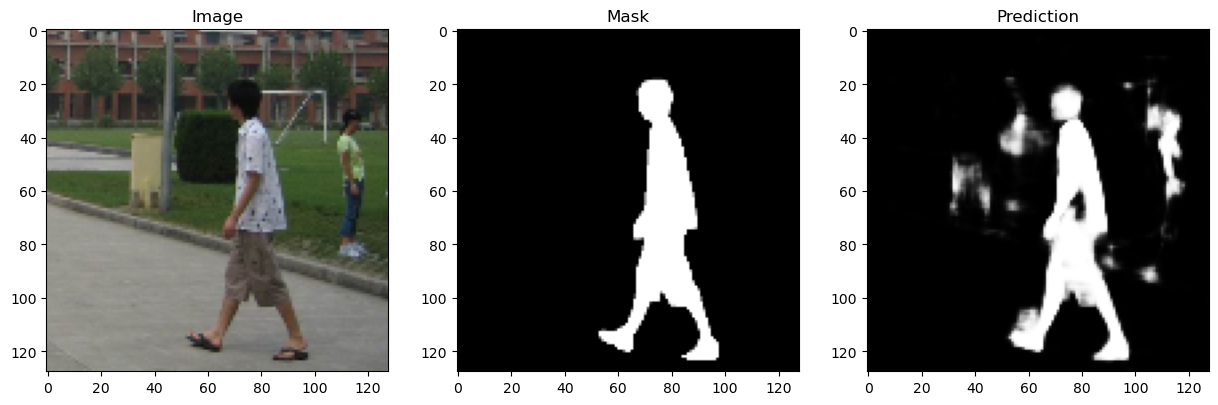

In [11]:
# Use the model on the test set and visualize the results
model.eval()
with torch.no_grad():
    image, mask = next(iter(test_loader))
    image = image.to(device)
    mask = mask.to(device)
    pred = model(image)
    pred = pred.cpu().numpy()
    mask = mask.cpu().numpy()
    image = image.cpu().numpy()
    pred = np.squeeze(pred, axis=1)
    fig, ax = plt.subplots(1, 3, figsize=(15, 15))
    ax[0].imshow(image[0].transpose(1, 2,0))
    ax[0].set_title("Image")
    ax[1].imshow(mask[0], cmap="gray")
    ax[1].set_title("Mask")
    ax[2].imshow(pred[0], cmap="gray")
    ax[2].set_title("Prediction")
    plt.show()


<a id='p1d'></a>
##### (d) Report training loss, validation loss, and validation DICE curves. Comment on any overfitting or underfitting observed.

[Table of Contents](#Table-of-Contents)

<a id='p2a'></a>
##### (e) Report the average dice score over your test-set. **You should be able to achieve a score of around 0.7 or better**.

[Table of Contents](#Table-of-Contents)

<a id='p2b'></a>
##### (f) Show at least 3 example segmentations (i.e. show the RGB image, mask, and RGB image X mask for 3 samples) from your training data and 3 from your testing data. Comment on the generalization capabilities of your trained network.

[Table of Contents](#Table-of-Contents)

<a id='p2c'></a>
##### (g) Show at least 1 example segmentation on an input image **<ins>not</ins> from the FudanPed dataset**. Again, comment on the generalization capabilities of your network with respect to this "out-of-distribution" image.

[Table of Contents](#Table-of-Contents)

In [9]:
# Create a README.md from this notebook
!jupyter nbconvert --TagRemovePreprocessor.enabled=True --TagRemovePreprocessor.remove_cell_tags run_all aaz7118-CA04.ipynb --to html --template lab
!jupyter nbconvert --TagRemovePreprocessor.enabled=True --TagRemovePreprocessor.remove_cell_tags run_all aaz7118-CA04.ipynb --to markdown --output README.md

[NbConvertApp] WARNING | Config option `kernel_spec_manager_class` not recognized by `NbConvertApp`.
[NbConvertApp] Converting notebook aaz7118-CA04.ipynb to html
[NbConvertApp] Writing 1740632 bytes to aaz7118-CA04.html
[NbConvertApp] WARNING | Config option `kernel_spec_manager_class` not recognized by `NbConvertApp`.
[NbConvertApp] Converting notebook aaz7118-CA04.ipynb to markdown
[NbConvertApp] Support files will be in README_files\
[NbConvertApp] Making directory README_files
[NbConvertApp] Making directory README_files
[NbConvertApp] Writing 32202 bytes to README.md
